<i>STATUS: Draft<i>

In [1]:
import numpy as np
import sympy as sp
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
from IPython.display import Image
import HTM_Code as hc
import sys


We now have a pretty strong handle on SDRs and a number of measures from which to understand them. SDRs are a powerful data structure, that can take the the data we experience in teh world and put it into a standard format. Now its time, to go deeper, with encoders 

In [2]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/V3Yqtpytif0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

<h4>Episode 5</h4>

The idea of an encoder is really bound up with how related pieces of information gets put into the SDR format. The BAMI document provices four things that encoders that: 

1. An encoder can recieve semantically similar pices of data and tranform it into SDRs with overlapping active bits.

2. The same input into an encoder should always produce the same SDR as output.

3. The output should have the same dimensionality (total number of bits) for all inputs.

4. The output should have similar sparsity for all inputs and have enough one-bits to handle noise and
    subsampling.
    


 For now, encoder is a function that allows passing of pieces of information that are correlated in some way. The phrase "semantically similiar" means the meaning is similiar captures the relationship, but  So for example, integers, passed into an encoder, relationships that are similiar in a domain are encoded, we are encoding the correlation 

Encoder is an object that assigns similiar SDRs by the domain similiarity. So in the domain of integers, 1 is closer to 2. In the domain of finite fields, say. 

To get a better sense of exactly what an encoder is, let's build one in Python. I will create the code first, and then we can walk through it to gain a better understanding:

In [185]:
class Encoder:
    def __init__(self, bit_space_size = None,
                number_of_bits_used_to_encode_value = None,
                min_val = None,
                max_val = None,
                is_randomly_distributed = None,
                clip_values_outside_range = None):

        self.bit_space_size = bit_space_size
        self.number_of_bits_used_to_encode_value = number_of_bits_used_to_encode_value
        self.clip_values_outside_range = clip_values_outside_range
        self.is_periodic = False
        self.is_randomly_distributed = is_randomly_distributed

        self.resolution = 1
        self.uniqueness = 1
        self.min_value_to_encode = min_val
        self.max_value_to_encode = max_val
        self.max_bit_space_value = bit_space_size
        self.min_bit_space_value = 0
        self.encoded_values = []
        self.encoded_values_bit_locations = []
        self.offset_for_array_indice = 1
        
        self.bucket_capacity = self.compute_bucket_capacity(self.bit_space_size, self.number_of_bits_used_to_encode_value)
        
        if self.is_randomly_distributed:
            self.initial_encoding = np.array(hc.create_randomised_sdr(self.bit_space_size, self.number_of_bits_used_to_encode_value))

            self.encoded_values_and_bit_locations = {str(self.min_value_to_encode):self.initial_encoding}
            self.encoded_values.append(self.min_value_to_encode)
            self.encoded_values_bit_locations.append(np.array(self.initial_encoding))
            

        
        
        
    def get_summary(self):
        print("----------------- SUMMARY -------------------------")
        print("|L3| Bit Space Size: ", self.bit_space_size)
        print("|L4| Number of bits to be used when encoding each value:", self.number_of_bits_used_to_encode_value)
        print("|L5| Range of values that can be encoded: From ", self.min_value_to_encode, ' to ', self.max_value_to_encode)
        print("|L6| Number of buckets available in bit space:", float(self.bucket_capacity))
        print("|L1| Encode periodically: ", self.is_periodic)
        print("|L1| Values are encoded as are randomly distributed arrays: ", self.is_randomly_distributed)
        print("|L1| Resolution: ", self.resolution)
        print("|L1| Unique active bits per bucket: ", self.uniqueness)
        print("|L2| Values outside range will to be clipped: ",self.clip_values_outside_range)
        print("|L7| Encoded values bit locations:\n ", self.encoded_values_bit_locations)
        print("|L8| Encoded values", self.encoded_values)
        print("----------------------------------------------------")


        

        
    def compute_bucket_capacity(self, n, w):
        if self.is_randomly_distributed:
            return(sp.binomial(self.bit_space_size, self.number_of_bits_used_to_encode_value))
        else:
            return(n - w + 1)

    def create_buckets_for_randomly_encoded_values(self, iterations_needed):
        
        for i in range(0, iterations_needed):
            random_bit_index_to_move = np.random.randint(0, self.number_of_bits_used_to_encode_value, 1)[0]
            random_direction_to_move = np.random.randint(0, 2, 1)

            next_sdr = self.encoded_values_bit_locations[-1].copy()
            value = next_sdr[random_bit_index_to_move]
            
            if random_direction_to_move == 1:
                value = next_sdr[random_bit_index_to_move] + 1
            else: 
                value = next_sdr[random_bit_index_to_move] - 1
                
            if value > self.max_bit_space_value:
                value = value - 2
            elif value < 0:
                value = value + 2

            next_sdr[random_bit_index_to_move] = value

            self.encoded_values_bit_locations.append(next_sdr.copy())
            self.encoded_values.append(np.array(self.encoded_values[-1] + 1))
            self.encoded_values_and_bit_locations[str(self.encoded_values[-1])] = next_sdr.copy()
            


    def encode_value_in_bit_space(self, value_choice):

        if self.clip_values_outside_range:
            if value_choice < self.min_value_to_encode or value_choice > self.max_value_to_encode:
                if value_choice < self.min_value_to_encode:
                    value_choice = self.min_value_to_encode
                else:
                    value_choice = self.max_value_to_encode
                print("value has been clipped to: ", value_choice)
            elif value_choice > self.min_value_to_encode or value_choice < self.max_value_to_encode:
                pass
        else:
            print("Not a valid choice, ", value_choice, " is outside encoder range")
            return

        if self.is_randomly_distributed:
            if (value_choice < self.encoded_values[-1]):
                print("There is a bucket already created for the value", value_choice, ": ", self.encoded_values_and_bit_locations[str(value_choice)])
                return

            buckets_needed_to_encode_value = value_choice - self.encoded_values[-1]
            print("Current number of buckets: " , len(self.encoded_values))
            print("Value held in first bucket: ", self.min_value_to_encode)
            print("Number of additional buckets required to accomodate the value choice of", value_choice, ": ", buckets_needed_to_encode_value)
            self.create_buckets_for_randomly_encoded_values(buckets_needed_to_encode_value)
        else:
            window = [value_choice, value_choice + self.number_of_bits_used_to_encode_value]
            all_values = np.arange(window[0], window[1])
            self.encoded_values_bit_locations.append(all_values)
            self.encoded_values.append(value_choice)


There are quite few functions here, and some of them are for future encoders we might want to build, so we will just take it simply. 

The first thing to is initialise an encoder and pass it some values, and get a summary:

In [186]:
bit_space_size_choice = 64
number_of_bits_used_to_encode_value_choice = 8

e1 = Encoder(bit_space_size = bit_space_size_choice,
                number_of_bits_used_to_encode_value = number_of_bits_used_to_encode_value_choice,
                min_val = 0,
                max_val = 56,
            is_randomly_distributed = False,
            clip_values_outside_range = True)
e1.get_summary()



----------------- SUMMARY -------------------------
|L3| Bit Space Size:  64
|L4| Number of bits to be used when encoding each value: 8
|L5| Range of values that can be encoded: From  0  to  56
|L6| Number of buckets available in bit space: 57.0
|L1| Encode periodically:  False
|L1| Values are encoded as are randomly distributed arrays:  False
|L1| Resolution:  1
|L1| Unique active bits per bucket:  1
|L2| Values outside range will to be clipped:  True
|L7| Encoded values bit locations:
  []
|L8| Encoded values []
----------------------------------------------------


So what is this encoder telling us? Our encoder will encode values of  note that, for now at least, we are not worried about efficienty, but simplicity. let's create an instance of it with some initial parameters and see what it can do:

Our encoder tells us it has some initial set up. The whole bit space appears to be 64, and any value that I would want to encode in this space will be 5 bits in length. If you think of this as an array with length 64, I can put 50 buckets (the first starting at index 1 of the array, the second starting at index two) into that space and its possible to encode 60 unique values. 

My initital settings however say that the range to from -10 to 100. So this will let me put any scalar, starting from -10 onwards, until I run out of buckets. After that, for any number I try and encode to the top of my range, it will just encode it to the very last bucket. We We can get around this by setting the encoder to periodic, which will do so later, or by just scaling back the range so the buckets can accomodate it. 

Note that the number of 50 buckets assumes that I have 1 unique bits per encoded value. So, for example, the value 8 and 9 starts at array indice 8 and 9 respectively, and 8 has 1 unique bit and the rest shared with adjacenct values. 

So now let's put some values into my encoder

In [187]:
e1.encode_value_in_bit_space(value_choice=5)
e1.encode_value_in_bit_space(value_choice=99)
e1.encode_value_in_bit_space(value_choice=33)
e1.encode_value_in_bit_space(value_choice=34)
e1.get_summary()

value has been clipped to:  56
----------------- SUMMARY -------------------------
|L3| Bit Space Size:  64
|L4| Number of bits to be used when encoding each value: 8
|L5| Range of values that can be encoded: From  0  to  56
|L6| Number of buckets available in bit space: 57.0
|L1| Encode periodically:  False
|L1| Values are encoded as are randomly distributed arrays:  False
|L1| Resolution:  1
|L1| Unique active bits per bucket:  1
|L2| Values outside range will to be clipped:  True
|L7| Encoded values bit locations:
  [array([ 5,  6,  7,  8,  9, 10, 11, 12]), array([56, 57, 58, 59, 60, 61, 62, 63]), array([33, 34, 35, 36, 37, 38, 39, 40]), array([34, 35, 36, 37, 38, 39, 40, 41])]
|L8| Encoded values [5, 56, 33, 34]
----------------------------------------------------


I have encoded in order, 34, 33, 5 and 99. This leaves me a current encoded value of 13, and a bunch of previous values I have encoded. My encoder is holding onto these so we can to comparisons. 

Let's visualise this using the visualization functions we have already created: 

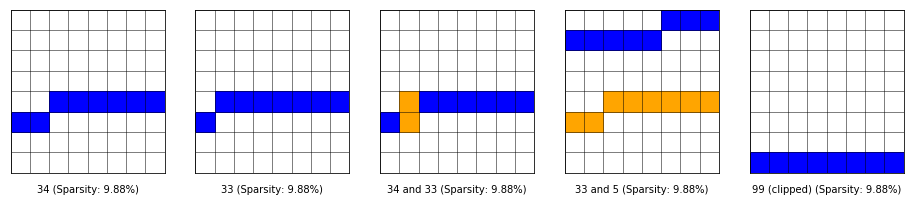

In [188]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 3))

ax1 = hc.create_axis_for_sdr(ax1, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "34")
ax2 = hc.create_axis_for_sdr(ax2, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "33")
ax3 = hc.create_axis_for_sdr(ax3, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "34 and 33")
ax4 = hc.create_axis_for_sdr(ax4, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "33 and 5")
ax5 = hc.create_axis_for_sdr(ax5, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "99 (clipped)")

coords1 = hc.convert_sdr_to_tuple_for_visualisation(e1.encoded_values_bit_locations[-1], bit_space_size_choice)
coords2 = hc.convert_sdr_to_tuple_for_visualisation(e1.encoded_values_bit_locations[-2], bit_space_size_choice)
coords3 = hc.convert_sdr_to_tuple_for_visualisation(e1.encoded_values_bit_locations[0], bit_space_size_choice)

union_and_overlap = hc.compute_union_and_overlap(e1.encoded_values_bit_locations[-1], e1.encoded_values_bit_locations[-2])

coords4 = hc.convert_sdr_to_tuple_for_visualisation(union_and_overlap['union'], bit_space_size_choice)
coords5 = hc.convert_sdr_to_tuple_for_visualisation(union_and_overlap['overlap'], bit_space_size_choice)

coords6 = hc.convert_sdr_to_tuple_for_visualisation(e1.encoded_values_bit_locations[1], bit_space_size_choice)


SDR1 = [ax1.add_patch(Rectangle(coords1[i], 1, 1, color="blue")) for i in range(len(coords1))]
SDR2 = [ax2.add_patch(Rectangle(coords2[i], 1, 1, color="blue")) for i in range(len(coords2))]
SDR3 = [ax3.add_patch(Rectangle(coords4[i], 1, 1, color="orange")) for i in range(len(coords4))]
SDR3 = [ax3.add_patch(Rectangle(coords5[i], 1, 1, color="blue")) for i in range(len(coords5))]
SDR4 = [ax4.add_patch(Rectangle(coords1[i], 1, 1, color="orange")) for i in range(len(coords1))]
SDR4 = [ax4.add_patch(Rectangle(coords3[i], 1, 1, color="blue")) for i in range(len(coords3))]
SDR5 = [ax5.add_patch(Rectangle(coords6[i], 1, 1, color="blue")) for i in range(len(coords6))]


<div style="background:#99ddff; color:black; padding: 10px">
<b>Add to these notes:</b>

I want to keep these notes in HTML so I don't have to host on a server, but a great exceriise is to use the ipython widgets to experience this like it happens in the video. 
</div>

So we have 5 visualisations here: 41, 42, the overlap between then similiar and we can see this by looking at comparison. Ten for any value that is in our range but not buckets, we will just the max back, so the value 99. 

Note there is an underlying idea here of semantic similiarity. How different is 41 and 5. the simplest metric. This gives us a value between 0 and 1 that tells us about thier similiarity. We will get to that soon, but first, let's do another one, this time random: 

In [189]:
# do SDR first Random, then semantic difference metrics

# need comparison of semantic difference.....

bit_space_size_choice = 64
number_of_bits_used_to_encode_value_choice = 8

e2 = Encoder(bit_space_size = bit_space_size_choice,
                number_of_bits_used_to_encode_value = number_of_bits_used_to_encode_value_choice,
                min_val = 0,
                max_val =300,
            is_randomly_distributed = True,
            clip_values_outside_range = True)
e2.get_summary()


----------------- SUMMARY -------------------------
|L3| Bit Space Size:  64
|L4| Number of bits to be used when encoding each value: 8
|L5| Range of values that can be encoded: From  0  to  300
|L6| Number of buckets available in bit space: 4426165368.0
|L1| Encode periodically:  False
|L1| Values are encoded as are randomly distributed arrays:  True
|L1| Resolution:  1
|L1| Unique active bits per bucket:  1
|L2| Values outside range will to be clipped:  True
|L7| Encoded values bit locations:
  [array([ 8, 41, 43, 44, 14, 17, 22, 60])]
|L8| Encoded values [0]
----------------------------------------------------


So this encoder has some different settings. The main difference I have set <code>is_randomly_distributed</code> to True. This means that each value is a randomly distributed array. When I set the encoder like this, it creates the randomly distrubted array for the minimum value in the range. Let's visualise it: 

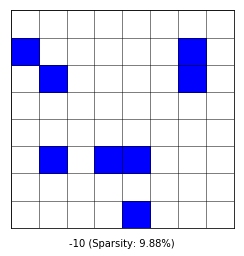

In [190]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

ax1 = hc.create_axis_for_sdr(ax1, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "-10")

coords1 = hc.convert_sdr_to_tuple_for_visualisation(e2.encoded_values_bit_locations[-1], bit_space_size_choice)

SDR1 = [ax1.add_patch(Rectangle(coords1[i], 1, 1, color="blue")) for i in range(len(coords1))]

Note it still needs to be semantic

In [191]:
e2.encode_value_in_bit_space(value_choice=1)

Current number of buckets:  1
Value held in first bucket:  0
Number of additional buckets required to accomodate the value choice of 1 :  1


In [192]:
e2.encode_value_in_bit_space(value_choice= 6)

Current number of buckets:  2
Value held in first bucket:  0
Number of additional buckets required to accomodate the value choice of 6 :  5


So now there are 7 buckets that have been created: 

In [194]:
e2.encode_value_in_bit_space(value_choice= -9)

value has been clipped to:  0
There is a bucket already created for the value 0 :  [ 8 41 43 44 14 17 22 60]


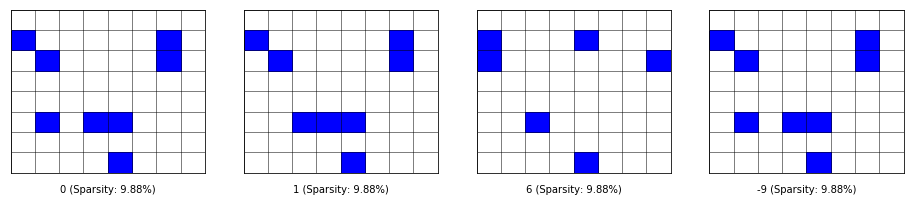

In [202]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3))

ax1 = hc.create_axis_for_sdr(ax1, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "0")
ax2 = hc.create_axis_for_sdr(ax2, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "1")
ax3 = hc.create_axis_for_sdr(ax3, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "6")
ax4 = hc.create_axis_for_sdr(ax4, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "-9")

coords1 = hc.convert_sdr_to_tuple_for_visualisation(e2.encoded_values_and_bit_locations["0"], bit_space_size_choice)
coords2 = hc.convert_sdr_to_tuple_for_visualisation(e2.encoded_values_and_bit_locations["1"], bit_space_size_choice)
coords3 = hc.convert_sdr_to_tuple_for_visualisation(e2.encoded_values_and_bit_locations["6"], bit_space_size_choice)
coords4 = hc.convert_sdr_to_tuple_for_visualisation(e2.encoded_values_and_bit_locations["0"], bit_space_size_choice)

p1 = [ax1.add_patch(Rectangle(coords1[i], 1, 1, color="blue")) for i in range(len(coords1))]
p2 = [ax2.add_patch(Rectangle(coords2[i], 1, 1, color="blue")) for i in range(len(coords2))]
p3 = [ax3.add_patch(Rectangle(coords3[i], 1, 1, color="blue")) for i in range(len(coords3))]
p4 = [ax4.add_patch(Rectangle(coords4[i], 1, 1, color="blue")) for i in range(len(coords4))]

So this is quite powerful

So se can say that closer to zero the more similiar. This is not great, but it is just a linear score. In fact this encoder has lots of limiations, but it is a start. 

Before we go on to other types of encoders, let's spend some more time on the semantic similiarity measures, and formalise the rules we use a bit: 

These rules suppose we have some be an an arbitrary input space, $A$. In the space  $S(n, k)$ is a set of SDRs that each have the length n and each have k on bits. We are interested in encoding the semantic similiarity of any of the SDRs in this set, and we will call our semantic similarity measure $d_a$, a function that can be appled to a number of SDRs in a given input space.  

We define that our distance function needs to be able to fulfill 3 properties. Note also that, I am a not a big fan of using the word distance, and will probably swap this out, but for now it works well.

First rule our distnance function needs to satisfy: 

$$\forall x, y \in A, d_A(x, y) \ge 0 $$

This says, for any  in 2 SDRs in the set (here denoted as $x$ and $y$, the disntance function must return a value greater than or equal to zero. Proximity function

Second rule our distnance function needs to satisfy: 

$$\forall x, y \in A, d_A(x, y) \equiv d_A(x, y) $$

This says that our distance function must return the same output regardless, of the order we call our SDR in. So in teh example above, if we compute distance between 5 and 41, it is the same as computing distance for 41 and 5. 

Third rule our distnance function needs to satisfy: 

$$\forall x, y \in A, d_A(x, x) = 0 $$

This says that the distance from the SDR to itself must be the the same. So we are getting to the point where we can compare distnance and metric scores, and overlap. Let's make it a little more reigou

Let's define 1 more rule

Finally, we or union and overlap function could do with some work.Let's define a evaluation metric for an encoder

1. Let $O(s,t)$ be number of overlapping bits

For encoder $f: A \rightarrow S(n,k) $ and $\forall w, x, y,z \in A$:

$$O(f(w), f(x)) \ge O(f(y), f(z)) \equiv d_A(w, x) \le d_A (y, z)$$

So this tells that the overap score for 2 SDRs, $w$ and $x$ is greater than the overlap score for $y$ and $z$, the disance between $w$ and $x$ will be less than distance $y$ and $z$.

So we can desing metrics however we want, as long as they define these rules